In [3]:
import json
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
def read_jsonl(file_path):
    """_summary_
    读取jsonl文件
    """
    result = []
    with open(file_path, 'r') as fp:
        for line in fp.readlines():
            result.append(json.loads(line))
    return result

In [5]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("/home/zy/other/fintech/model/chatglm2-6b", trust_remote_code=True)

total data:  4800
total length:  4788
726


(array([  2.,   1.,   4.,   3.,   5.,   2.,   6.,   0.,   5.,  10.,  17.,
         18.,  20.,  50.,  40.,  56.,  96.,  83.,  96., 111., 124.,  67.,
         73.,  79.,  53.,  50.,  54.,  36.,  29.,  32.,  35.,  30.,  29.,
         25.,  23.,  24.,  33.,  24.,  44.,  38.,  65.,  64.,  47.,  78.,
         63.,  57., 117., 101.,  93.,  96., 182., 123., 163., 188., 167.,
        172., 195., 168., 115., 112., 174., 100.,  76.,  95.,  69.,  64.,
         58.,  33.,  34.,  41.,  35.,  16.,  24.,  20.,   5.,  10.,  12.,
          5.,   1.,   3.,   4.,   3.,   2.,   1.,   1.,   1.,   3.,   1.,
          0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.]),
 array([296. , 300.3, 304.6, 308.9, 313.2, 317.5, 321.8, 326.1, 330.4,
        334.7, 339. , 343.3, 347.6, 351.9, 356.2, 360.5, 364.8, 369.1,
        373.4, 377.7, 382. , 386.3, 390.6, 394.9, 399.2, 403.5, 407.8,
        412.1, 416.4, 420.7, 425. , 429.3, 433.6, 437.9, 442.2, 446.5,
        450.8, 455.1, 459.4, 463.7

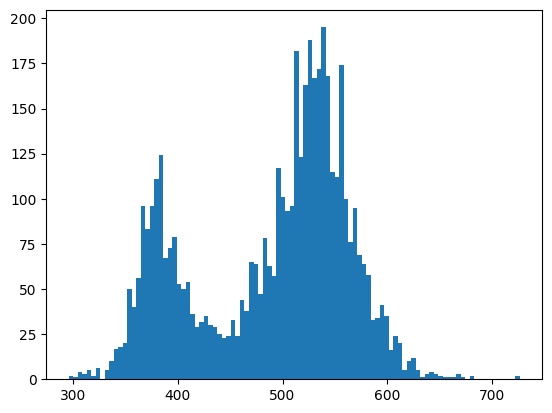

In [6]:
file_path = "/home/zy/other/fintech/finetune/table_qa/data/personal_information_augmentation.json"

data = read_jsonl(file_path)

print("total data: ", len(data))
# 统计 data["prompt"] 的长度
length = Counter()
length_list = []
valid_data = []
for i in data:
    prompt = i["prompt"]
    # tokenize
    tokenized_prompt = tokenizer(prompt)['input_ids']
    # print(tokenized_prompt)
    # break
    if len(tokenized_prompt) > 768:
        continue
    length_list.append(len(tokenized_prompt))
    valid_data.append(i)
    
print("total length: ", len(length_list))
# 绘制长度直方图
print(max(length_list))
plt.hist(length_list, bins=100)

In [7]:
# 9 : 1 划分 train dev
data = valid_data
train_data = data[:int(len(data)*0.9)]
dev_data = data[int(len(data)*0.9):]

# 保存
with open('personal_information_augmentation_train.json', 'w') as f:
    json.dump(train_data, f, ensure_ascii=False, indent=4)
with open('personal_information_augmentation_dev.json', 'w') as f:
    json.dump(dev_data, f, ensure_ascii=False, indent=4)

In [2]:
predicted_path = "/home/zy/other/fintech/model/table_qa/personal/generated_predictions.txt"

with open(predicted_path, 'r') as f:
    predicted = f.readlines()
    
dev_path = 'personal_information_augmentation_dev.json'

with open(dev_path, 'r') as f:
    dev = json.load(f)

for i, line in enumerate(predicted):
    line_dic = json.loads(line)
    if line_dic['labels'] != line_dic['predict']:
        print(dev[i])
        print(line_dic)
    

{'prompt': "现在给你若干个包含公司基本信息的表格,请你根据表格的内容正确回答问题:\n\n2021年深桑达员工数量、专业构成及教育程度表：[['报告期末母公司在职员工的数量（人）', '275'], ['报告期末主要子公司在职员工的数量（人）', '20,421'], ['报告期末在职员工的数量合计（人）', '20,696'], ['当期领取薪酬员工总人数（人）', '20,696'], ['母公司及主要子公司需承担费用的离退休职工人数（人）', '542'], ['专业构成', ''], ['专业构成类别', '专业构成人数（人）'], ['生产人员', '3,392'], ['销售人员', '3,095'], ['技术人员', '11,802'], ['财务人员', '303'], ['行政人员', '2,104'], ['合计', '20,696'], ['教育程度', ''], ['教育程度类别', '数量（人）'], ['博士学历', '29'], ['硕士学历', '2,195'], ['本科学历', '14,607'], ['本科以下', '3,865'], ['合计', '20,696']]\n\n2021年深桑达研发投入表：[['', '2021年', '2020年', '变动比例'], ['研发人员数量（人）', '2,183', '1,631', '33.84%'], ['研发人员数量占比', '11.00%', '9.00%', '2.00%'], ['研发人员学历结构', '——', '——', '——'], ['本科', '1,244', '897', '38.68%'], ['硕士', '807', '554', '45.67%'], ['研发人员年龄构成', '——', '——', '——'], ['30岁以下', '916', '652', '40.49%'], ['30~40岁', '851', '570', '49.30%']]\n\n2021年深桑达硕士及以上人数是什么?", 'response': '2021年深桑达博士的人数是29人， 硕士的人数是2195人，硕士及以上人数是{29+2195}人。'}
{'labels': '2021年深桑达博士的人数是29人， 硕士的人数是2195人，硕士及以上人数是{29

In [6]:
# 正则匹配 大括号中的内容{}，懒惰模式
import re
response = ["乐歌股份2019年的研发人员是466人，职工人数是1812人，计算比例公式为研发人员/职工人数，因此研发人员占职工人数比例是{466/1812}。"]
pattern = re.compile(r'\{.*?\}')
for idx, res in enumerate(response):
    matchs = pattern.findall(res)
    if matchs:
        cur_match = matchs[-1]
        try:
            cur_match_res = f"{list(eval(cur_match))[0] :.2f}"
            new_res = res.replace(cur_match, cur_match_res)
            response[idx] = new_res
        except:
            pass
print(response)

['乐歌股份2019年的研发人员是466人，职工人数是1812人，计算比例公式为研发人员/职工人数，因此研发人员占职工人数比例是0.26。']


In [4]:
f"{eval(cur_match) :.2f}"

TypeError: unsupported format string passed to set.__format__